In [1]:
%matplotlib widget
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import numpy as np
import tensorflow as tf

from utils.sensor_placement import *
from utils.transformations import *

import matplotlib.pyplot as plt

np.random.seed(0)
tf.random.set_seed(0)


2023-02-24 16:39:59.600984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def get_corners(X, size):
    corners = np.zeros((X.shape[0]//(size**2), 5, 3))
    X = X.reshape(-1, size**2, 2)
    corners[:, 0, :2] = X.min(axis=1)
    corners[:, 1, :2] = np.array([X[:, :, 0].min(axis=1), X[:, :, 1].max(axis=1)]).T
    corners[:, 2, :2] = X.max(axis=1)
    corners[:, 3, :2] = np.array([X[:, :, 0].max(axis=1), X[:, :, 1].min(axis=1)]).T
    # center
    corners[:, 4, :2] = X.mean(axis=1)
    return corners

def align_idx(a, b):
    dists = pairwise_distances(a, Y=b, metric='euclidean')
    _, ind = linear_sum_assignment(dists)
    return ind

In [3]:
data_dims = (25, 25, 25)

x = np.linspace(0, 50, data_dims[0])
y = np.linspace(0, 50, data_dims[1])
z = np.linspace(0, 50, data_dims[2])

X, Y, Z = np.meshgrid(x, y, z)
X_train = np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1), Z.reshape(-1, 1)), axis=1)
y_train = np.zeros((X_train.shape[0], 1))

print(X_train.shape, y_train.shape)

kernel = gpflow.kernels.RBF(lengthscales=[3, 3, 3], variance=0.027)
noise_variance = 0.001

(15625, 3) (15625, 1)


In [7]:
num_placements = 50
transformer = SplineIPPTransformer(num_placements, sampling_rate=200, degree=3)
sgpr = get_aug_sgp_sol(num_placements,
                       X_train, 
                       noise_variance, 
                       kernel,
                       transformer=transformer,
                       num_steps=5000)
spline_sgp_sol_sp = sgpr.inducing_variable.Z.numpy()
spline_sgp_sol_sp = transformer.expand(spline_sgp_sol_sp)

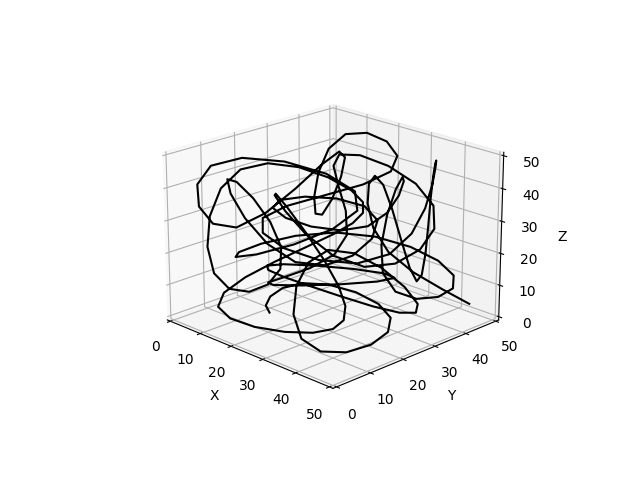

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(spline_sgp_sol_sp[:, 0], 
        spline_sgp_sol_sp[:, 1], 
        spline_sgp_sol_sp[:, 2], 
        'k-')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim(0, 50)
ax.set_ylim(0, 50)
ax.set_zlim(0, 50)

ax.view_init(elev=20., azim=-45)

plt.savefig(f'./spline_line_view4.pdf', bbox_inches='tight')

plt.show()